# **Survival Analysis: Publication Bias**

In this notebook, we introduce the core concepts of Survival Analysis using the `lifelines` library in Python. Working with a time-to-event dataset, we will:


*   Estimate survival probabilities using the **Kaplan–Meier estimator**.
* Identify Risk Factors by fitting a **Cox Proportional Hazards model** (`CoxPHFitter`).
* Visualize Results through **survival curves**.  

We analyze a dataset of clinical trials funded by the NHLBI. Our goal is to determine if there is a **publication bias**: do trials with statistically significant results reach the journals faster than those with neutral findings?


In [ ]:
%%capture
pip install lifelines

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import survival_table_from_events

## Publication Data

This dataset involves the **time to publication of journal papers** reporting the results of clinical trials funded by the **National Heart, Lung, and Blood Institute.**

This dataset is described in the following paper: *Gordon et al. (2013) Publication of trials funded by the National Heart, Lung, and Blood Institute. New England Journal of Medicine, 369(20):1926–1934.*

In [ ]:
# Upload Publication.csv Dataset
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()


For 244 trials, the time in months until publication is recorded. Of the 244 trials, only 156 were published during the study period; the remaining studies were censored.

The **covariates** include:
* Whether the trial focused on a clinical endpoint (`clinend`)
* Whether the trial involved multiple centers (`multi`)
* The funding mechanism within the National Institutes of Health (`mech`)
* Trial sample size (`sampsize`)
* Budget (`budget`)
* Impact (`impact`, related to the number of citations)
* Whether the trial produced a positive or significant result (`posres`).

We will pay special attention to `posres` (Positive Results). Scientific literature suggests a "publication bias" where trials with significant results might have a shorter "time-to-event" (faster publication) compared to those with neutral or negative findings.

In [ ]:
publication = pd.read_csv('Publication.csv', index_col=0)
publication.head()

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
1,0,0,1,R01,39876,8.016941,44.016,11.203285,1
2,0,0,1,R01,39876,8.016941,23.494,15.178645,1
3,0,0,1,R01,8171,7.612606,8.391,24.410678,1
4,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
5,0,0,1,Contract,33357,76.517537,16.783,8.607803,1


# Censoring
In survival analysis, censoring occurs when we do not know the exact time the event (in this case, "Publication") took place for every subject in the study.



In [ ]:
publication.status.value_counts()

,count
status,
1,156
0,88


For this specific dataset of NHLBI-funded clinical trials:


*   **The Event**: A journal paper is successfully published.

*   **Censored Observations**: Out of 244 trials, 88 studies (36%) are censored. This means that by the time Gordon et al. (2013) finished their data collection, those specific trials had not yet been published.



# Kaplan-Meier Survival Curves

The **Kaplan–Meier estimator** is a **non-parametric method** to estimate the probability of survival over time.

It calculates survival probabilities at each observed event time and properly handles censored data, allowing us to visualize how survival changes throughout the study period.

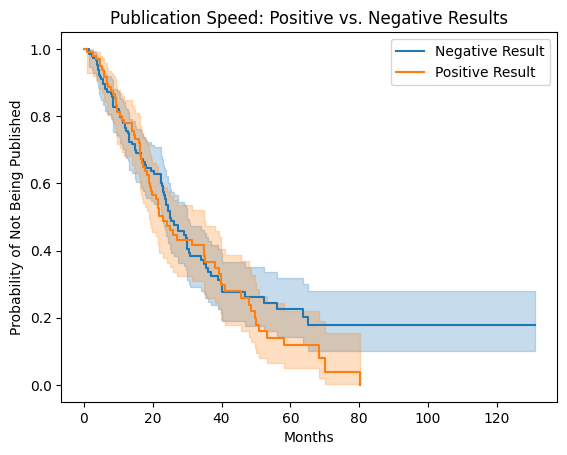

In [ ]:
groups = set(publication.posres)
kmf = KaplanMeierFitter()

for group in groups:
    ix = (publication.posres == group)
    kmf.fit(publication.time[ix], publication.status[ix])
    label = 'Negative Result' if group == 0 else 'Positive Result'
    kmf.plot(label=label)

# Plot settings
plt.title("Publication Speed: Positive vs. Negative Results")
plt.xlabel("Months")
plt.ylabel("Probability of Not Being Published")
plt.legend()
plt.show()

Figure above shows the Kaplan–Meier curves for the time until publication,
stratified by whether or not the study produced a positive result. We see
slight evidence that time until publication is lower for studies with a positive
result.

# The Log-Rank Test: Comparing Publication Rates
In this section, we aim to determine whether there is a statistically significant difference in the time it takes for clinical trials to be published based on whether their results were positive (`posres == 1`) or negative/neutral (`posres == 0`).

When looking at Kaplan-Meier curves, one group might appear to reach publication faster than the other. **However, is this difference real, or is it just due to random chance?**

In [ ]:
# log-rank test

results = logrank_test(publication.time[publication.posres==0], publication.time[publication.posres==1],
                      publication.status[publication.posres==0], publication.status[publication.posres==1])

print('Log-Rank Test Statistic: ', results.test_statistic)
print('Log-Rank Test p-value: ', results.p_value)

Log-Rank Test Statistic:  0.8439998569292577
Log-Rank Test p-value:  0.3582553098010117


Since the p-value (0.358) is significantly higher than the standard significance threshold of 0.05, we fail to reject the null hypothesis.

Log-Rank test suggested that positive results don't matter ($p=0.358$). However, scientific papers aren't just about results; they are about **Impact, Budget, and Sample Size**.


# Cox Proportional Hazard
The Cox Proportional Hazards (CPH) model is a semi-parametric method used to assess the simultaneous effect of multiple predictors on the "survival" (time-to-publication) of clinical trials.

**Why use a Cox Model instead of Kaplan-Meier?**
While the Kaplan-Meier estimator and Log-Rank tests are great for comparing two distinct groups (like posres), they cannot handle multiple variables at once or continuous data (like budget or sampsize). The Cox model allows us to:

* **Adjust for Covariates**: We can see the effect of positive results (posres) while "holding constant" the influence of the budget and sample size.

* **Estimate Hazard Ratios**: It provides a measure of relative risk. A Hazard Ratio tells us how much more (or less) likely a trial is to be published at any given time compared to a baseline.


The Hazard Ratio represents the relative risk of the event (publication) occurring.

* **$HR = 1$**: **Neutral.** The factor (e.g., budget size) has no influence on the speed of publication.
* **$HR > 1$**: **Acceleration.** The factor speeds up publication (e.g., having positive results or high citation impact).
* **$HR < 1$**: **Delay.** The factor slows down publication (e.g., excessive bureaucracy or lack of personnel).


In [ ]:
# Cox Proportional Hazard
cph = CoxPHFitter()
cph.fit(publication, duration_col='time', event_col='status', formula='posres')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2026-02-13 12:44:32 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
posres     0.15      1.16      0.16           -0.17            0.46                0.84                1.59

           cmp to    z    p  -log2(p)
covariate                            
posres       0.00 0.92 0.36      1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

The p-value from Cox Proportional Hazards and the Log-Rank test shows that there is no evidence of a difference in time-to-publication between studies with positive versus negative results.

# Multivariate Cox Proportional Hazards Model
In the previous steps, we looked at the effect of positive results (posres) in isolation. However, in the real world, the time it takes to publish a study is likely influenced by many factors simultaneously, such as funding, trial complexity, and the scale of the research.

In this section, we fit a Multivariate Cox Model to account for several predictors at once:

* `posres`

* `multi`

* `clinend`
* `sampsize`
* `budget`

* `impact`

By using a **Multivariate Cox Model** and including all these variables, we can determine the independent effect of each predictor while controlling for the others. This allows us to see if, for example, a larger budget speeds up publication regardless of whether the results were positive or negative.



In [ ]:
cph_all = CoxPHFitter()
cph_all.fit(publication, duration_col='time', event_col='status',
            formula='posres + multi + clinend + sampsize + budget + impact')

cph_all.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2026-02-13 12:44:33 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
posres     0.57      1.77      0.18            0.23            0.92                1.25                2.50
multi     -0.04      0.96      0.25           -0.53            0.45                0.59                1.57
clinend    0.55      1.73      0.26            0.03            1.06                1.03                2.89
sampsize   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
budget     0.00      1.00      0.00           -0.00            0.01                1.00                1.01
impact     0.06      1.06      0.01            0.05            0.07                1.05                1.07

           cmp to     z      p  -log2(p)
covariate                               
posres       0.00  3.24 <0.005      9.73
multi        0.00 -0.16   0.87      0.20
clinend      0.00  2.08   0.04      4.75
sampsize     0.00  0.32   0.75      0.41
budget       0.00  1.78   0.08      3.73
impact       0.00  8.74 <0.005     58.52
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

The model reveals three primary drivers that significantly speed up the time-to-publication (where a p-value < 0.05 and a Hazard Ratio > 1 indicate faster publication):
* **Positive Results** (`posres`): Hazard Ratio  = 1.77 ($p < 0.005$).
Contrary to our simple analysis, when controlling for budget and impact, trials with positive results are 77% more likely to be published at any given time compared to negative/neutral trials. This is strong evidence of publication bias.
* **Clinical Endpoints** (`clinend`): Hazard Ratio = 1.73 ($p = 0.04$). Trials focusing on clinical endpoints reach publication 73% faster than those that do not.
* **Scientific Impact** (`impact`): Hazard Ratio = 1.06 ($p < 0.005$). For every one-unit increase in the impact score (citations), the hazard of being published increases by 6%. While 6% sounds small, because this is a continuous variable, high-impact papers publish significantly faster than low-impact ones.